# Análise de sentimentos de tweets

Este projeto consiste numa análise de sentimentos de um conjunto de tweets enviados para companhias aéreas em 2015.

Aqui, duas abordagens são utilizadas e comparadas entre si: Vader e RoBERTa.

Esse projeto se baseou fortemente no [vídeo](https://youtu.be/QpzMWQvxXWk?si=9-bBN2_EUQqdSISJ) do canal de Rob Mulla.

## Instalação de bibliotecas e módulos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

plt.style.use('ggplot')

nltk.download('words')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
nltk.download('maxent_ne_chunker_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

## Baixando base de dados do Kaggle

Link da base de dados: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [3]:
from google.colab import files
files.upload()  # kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luizlobato","key":"46b61a40c94233b336c39feea06ecc22"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d crowdflower/twitter-airline-sentiment


Dataset URL: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
License(s): CC-BY-NC-SA-4.0
  0% 0.00/2.55M [00:00<?, ?B/s]
100% 2.55M/2.55M [00:00<00:00, 93.0MB/s]


In [6]:
!unzip twitter-airline-sentiment.zip


Archive:  twitter-airline-sentiment.zip
  inflating: Tweets.csv              
  inflating: database.sqlite         


## Tratamento os dados

In [7]:
df = pd.read_csv('Tweets.csv')
print(df.shape)


(14640, 15)


In [8]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


A base de dados contém tweets com IDs duplicados

In [9]:
duplicated_count = df['tweet_id'].duplicated().sum()
print(f"Total de IDs duplicados: {duplicated_count}")


Total de IDs duplicados: 155


Removendo tweets duplicados

In [10]:
df = df.drop_duplicates(subset='tweet_id', keep='first')


A base de dados, portanto, contém 14485 tweets

In [11]:
df.shape

(14485, 15)

## Utilizando NLTK

In [12]:
example = df['text'][26]
print(example)


@VirginAmerica What happened 2 ur vegan food options?! At least say on ur site so i know I won't be able 2 eat anything for next 6 hrs #fail


In [13]:
tokens = nltk.word_tokenize(example)
print(tokens[:12])


['@', 'VirginAmerica', 'What', 'happened', '2', 'ur', 'vegan', 'food', 'options', '?', '!', 'At']


Utilizando tags de NLTK.

In [14]:
tagged = nltk.pos_tag(tokens)
tagged[:12]

[('@', 'NN'),
 ('VirginAmerica', 'NNP'),
 ('What', 'WP'),
 ('happened', 'VBD'),
 ('2', 'CD'),
 ('ur', 'JJ'),
 ('vegan', 'NNS'),
 ('food', 'NN'),
 ('options', 'NNS'),
 ('?', '.'),
 ('!', '.'),
 ('At', 'IN')]

Utilizando Named Entity Recognition (NER)

In [15]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()


(S
  @/NN
  (ORGANIZATION VirginAmerica/NNP)
  What/WP
  happened/VBD
  2/CD
  ur/JJ
  vegan/NNS
  food/NN
  options/NNS
  ?/.
  !/.
  At/IN
  least/JJS
  say/VBP
  on/IN
  ur/JJ
  site/NN
  so/IN
  i/JJ
  know/VBP
  I/PRP
  wo/MD
  n't/RB
  be/VB
  able/JJ
  2/CD
  eat/NN
  anything/NN
  for/IN
  next/JJ
  6/CD
  hrs/JJ
  #/#
  fail/NN)


### Tabela de abreviaturas (NER)

S: Sentence (início da frase)


Substantivos:


NN: Substantivo comum, singular (food, site, fail)

NNP: Substantivo próprio, singular (VirginAmerica)

NNS: Substantivo comum, plural (options, vegan)


Verbos:


VBD: Verbo no passado (happened)

VBP: Verbo no presente não 3ª pessoa (say, know)

VB: Verbo na forma base (be)


Pronomes:


WP: Pronome interrogativo (What)

PRP: Pronome pessoal (I)


Adjetivos:


JJ: Adjetivo (ur, able, next)

JJS: Adjetivo superlativo (least)


Outros:


CD: Número cardinal (2, 6)

RB: Advérbio (n't)

IN: Preposição (At, for)

MD: Verbo modal (wo - contração de 'will')

"#": Símbolo hash

.: Ponto final

## Análise de sentimentos (VADER)

VADER é um acrônimo para Valence Aware Dictionary and sEntiment Reasoner.

Trata-se de um módulo dentro de ```nltk.sentiment ``` que permite mensurar a polaridade do sentimento (o quão positivo ou negativo) de um texto sem rótulos.

Para isso, VADER usa um léxico de palavras relacionadas a sentimentos para determinar o sentimento geral de um corpo textual (neste notebook, o download do léxico foi feito pelo comando ```nltk.download('vader_lexicon')```).

Fonte: https://towardsdatascience.com/an-short-introduction-to-vader-3f3860208d53



In [16]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()


In [17]:
sia.polarity_scores('I am very disappointed.')

{'neg': 0.629, 'neu': 0.371, 'pos': 0.0, 'compound': -0.5256}

In [18]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [19]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['text']
    myid = row['tweet_id']
    res[myid] = sia.polarity_scores(text)


  0%|          | 0/14485 [00:00<?, ?it/s]

In [20]:
vaders = pd.DataFrame(res).T
vaders['textos'] = df['text'].values
vaders['sentimentos'] = df['airline_sentiment'].values
vaders = vaders.reset_index().rename(columns={'index': 'Id'})

vaders.shape

(14485, 7)

In [21]:
vaders.head(5)


,Id,neg,neu,pos,compound,textos,sentimentos
0,570306133677760513,0.000,1.000,0.0,0.0000,@VirginAmerica What @dhepburn said.,neutral
1,570301130888122368,0.000,1.000,0.0,0.0000,@VirginAmerica plus you've added commercials t...,positive
2,570301083672813571,0.000,1.000,0.0,0.0000,@VirginAmerica I didn't today... Must mean I n...,neutral
3,570301031407624196,0.246,0.754,0.0,-0.5984,@VirginAmerica it's really aggressive to blast...,negative
4,570300817074462722,0.321,0.679,0.0,-0.5829,@VirginAmerica and it's a really big bad thing...,negative


## Análise visual (VADER)

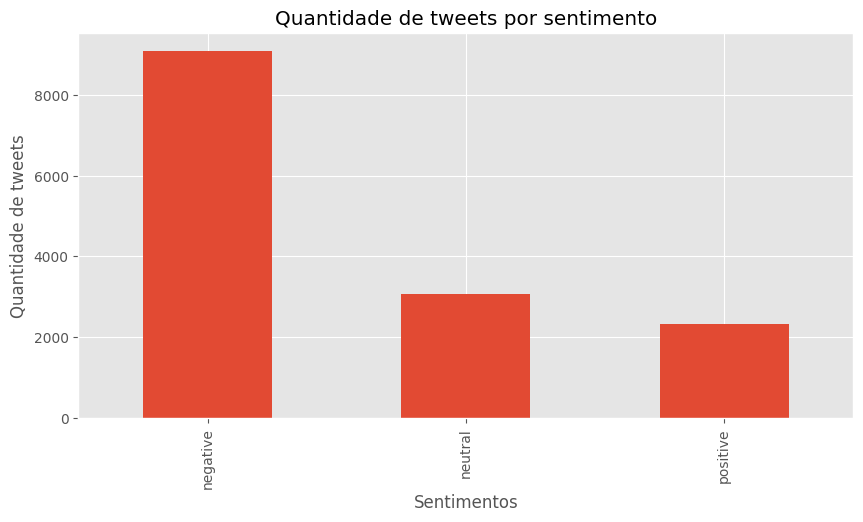

In [ ]:
review_values = df['airline_sentiment'].value_counts()

ax = review_values.sort_index() \
    .plot(kind='bar',
          title='Quantidade de tweets por sentimento',
          figsize=(10, 5))
ax.set_xlabel('Sentimentos')
ax.set_ylabel('Quantidade de tweets')
plt.show()


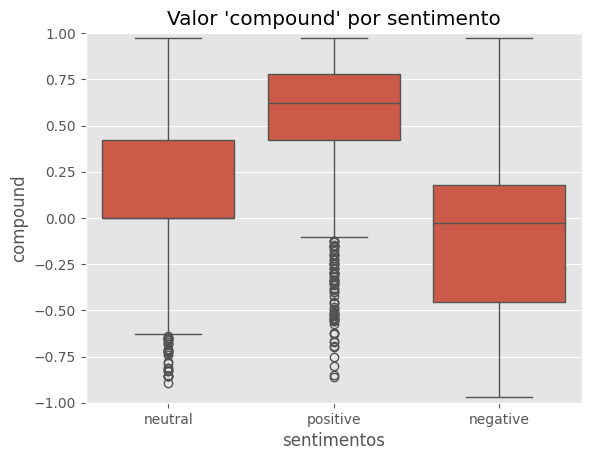

In [ ]:
ax = sns.boxplot(data=vaders, x='sentimentos', y='compound')
ax.set_ylim(-1, 1)
ax.set_title("Valor 'compound' por sentimento")
plt.show()

## Análise de sentimentos (RoBERTa)

RoBERTa é um acrônimo para Robustly Optimized BERT Pretraining Approach.

RoBERTa é um modelo de linguagem baseado em transformer que emprega "self-attention" para analisar sequências de entrada e produzir representações contextualizadas de palavras dentro de uma frase. Foi proposto e desenvolvido em 2019 pela Facebook AI (atual Meta AI).

Fonte: https://medium.com/@marketing_novita.ai/introducing-roberta-base-model-a-comprehensive-overview-330338afa082

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
print(example)
sia.polarity_scores(example)

@VirginAmerica What happened 2 ur vegan food options?! At least say on ur site so i know I won't be able 2 eat anything for next 6 hrs #fail


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [ ]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.9345053, 'roberta_neu': 0.060936823, 'roberta_pos': 0.0045578736}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res_roberta = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['text']
        myid = row['tweet_id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res_roberta[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/14485 [00:00<?, ?it/s]

In [ ]:
results_df = pd.DataFrame(res_roberta).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})


In [ ]:
results_df.to_csv('results_df.csv')


## Comparando resultados entre modelos (VADER E RoBERTa)

Nesta seção, faremos uma comparação entre os valores 'neg', 'neu' e 'pos' calculados pelo VADER e os calculados pelo modelo RoBERTa. Note que deixaremos de fora o valor 'compound' calculado na primeira abordagem.

In [ ]:
results_df['sentimentos'] = df['airline_sentiment'].values
results_df.head()


,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,sentimentos
0,570306133677760513,0.000,1.000,0.0,0.0000,0.153647,0.800411,0.045942,neutral
1,570301130888122368,0.000,1.000,0.0,0.0000,0.829640,0.151273,0.019087,positive
2,570301083672813571,0.000,1.000,0.0,0.0000,0.326381,0.542418,0.131201,neutral
3,570301031407624196,0.246,0.754,0.0,-0.5984,0.902390,0.090954,0.006657,negative
4,570300817074462722,0.321,0.679,0.0,-0.5829,0.893211,0.095797,0.010992,negative


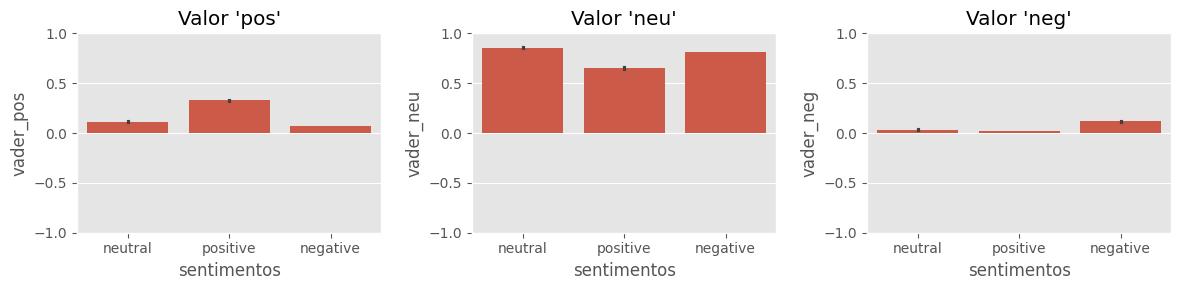

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

for ax in axs:
  ax.set_ylim(-1, 1)

sns.barplot(data=results_df, x='sentimentos', y='vader_pos', ax=axs[0])
sns.barplot(data=results_df, x='sentimentos', y='vader_neu', ax=axs[1])
sns.barplot(data=results_df, x='sentimentos', y='vader_neg', ax=axs[2])

axs[0].set_title("Valor 'pos'")
axs[1].set_title("Valor 'neu'")
axs[2].set_title("Valor 'neg'")
plt.tight_layout()
plt.show()


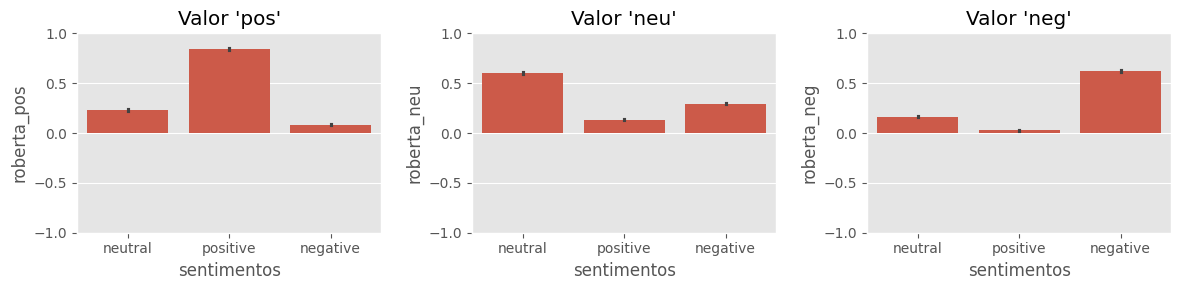

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

for ax in axs:
  ax.set_ylim(-1, 1)

sns.barplot(data=results_df, x='sentimentos', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='sentimentos', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='sentimentos', y='roberta_neg', ax=axs[2])

axs[0].set_title("Valor 'pos'")
axs[1].set_title("Valor 'neu'")
axs[2].set_title("Valor 'neg'")
plt.tight_layout()
plt.show()


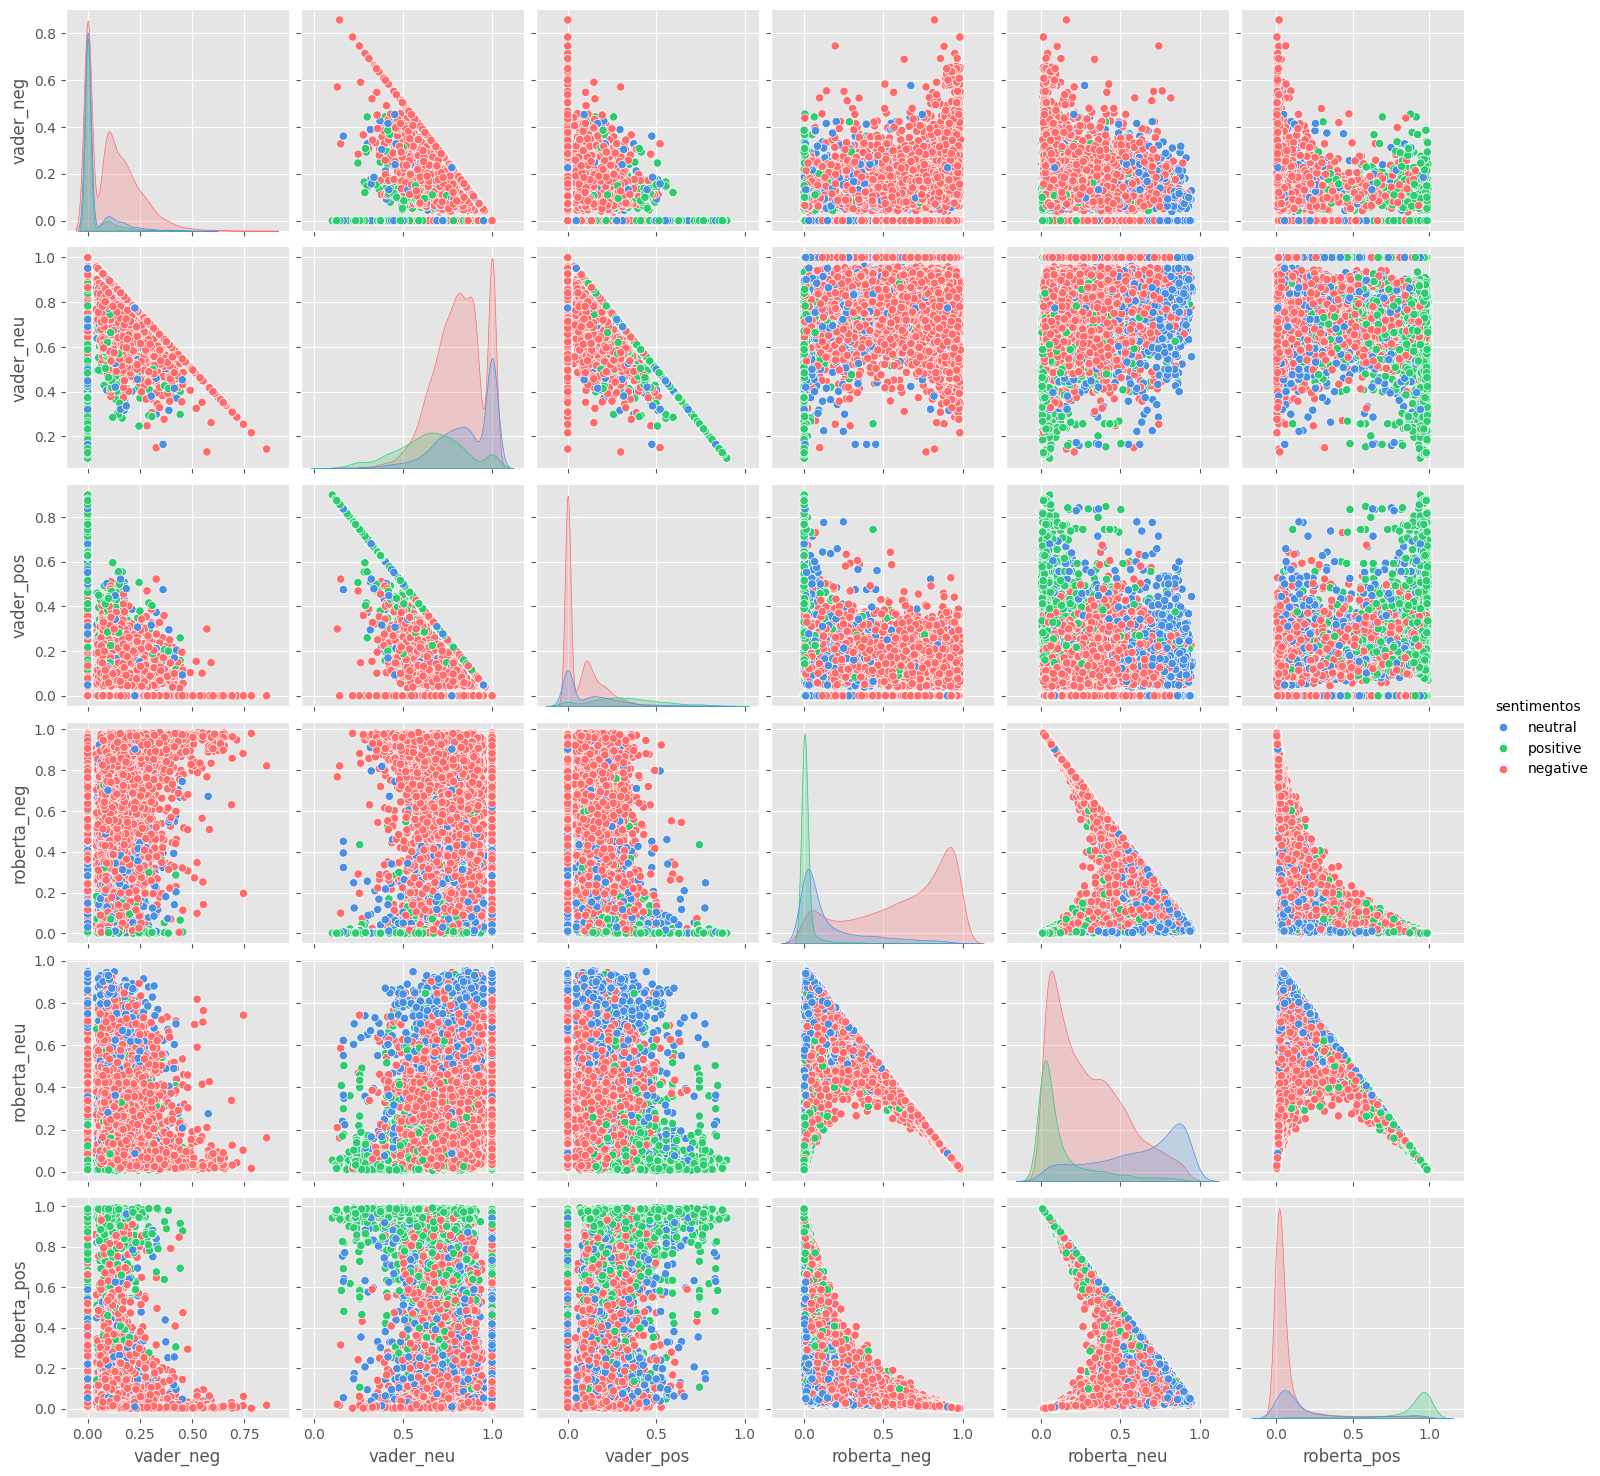

In [ ]:
cores = ['#4A90E2', '#2ECC71', '#FF6B6B']

sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='sentimentos',
            palette=cores)
plt.show()
